In [2]:
import pandas as pd
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras import models
from keras import layers

import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

# Data Preprocessing

## EDA & Outlier Processing

In [3]:
shot_logs = pd.read_csv('shot_logs.csv')
print(shot_logs.shape)

(128069, 21)


In [4]:
shot_logs.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [5]:
# column name unify to lower
shot_logs.columns = shot_logs.columns.str.lower()

# check data type : obj type converting needed
shot_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   game_id                     128069 non-null  int64  
 1   matchup                     128069 non-null  object 
 2   location                    128069 non-null  object 
 3   w                           128069 non-null  object 
 4   final_margin                128069 non-null  int64  
 5   shot_number                 128069 non-null  int64  
 6   period                      128069 non-null  int64  
 7   game_clock                  128069 non-null  object 
 8   shot_clock                  122502 non-null  float64
 9   dribbles                    128069 non-null  int64  
 10  touch_time                  128069 non-null  float64
 11  shot_dist                   128069 non-null  float64
 12  pts_type                    128069 non-null  int64  
 13  shot_result   

In [6]:
# shot_clock had NA value
shot_logs.isnull().sum()

game_id                          0
matchup                          0
location                         0
w                                0
final_margin                     0
shot_number                      0
period                           0
game_clock                       0
shot_clock                    5567
dribbles                         0
touch_time                       0
shot_dist                        0
pts_type                         0
shot_result                      0
closest_defender                 0
closest_defender_player_id       0
close_def_dist                   0
fgm                              0
pts                              0
player_name                      0
player_id                        0
dtype: int64

In [7]:
# converting obj data type to int type
# exclude matchup, closest_defender, player_name

shot_logs.location = shot_logs.location.map({"H":1,"A":0})
shot_logs.w = shot_logs.w.map({"W":1,"L":0})
shot_logs.shot_result = shot_logs.shot_result.map({"made":1,"missed":0})
shot_logs['game_clock'] = shot_logs['game_clock'].apply(lambda x: 60*int(x.split(':')[0]) + int(x.split(':')[1]))

In [8]:
shot_logs['game_clock'][0]

69

In [9]:
# filling missing values -> NA 있는 부분만 확인
shot_clock_nan = shot_logs[shot_logs['shot_clock'].isna()]
# shot_clock의 제한은 24초로 game_clock보다 shot_clock이 작아지면 shot_clock을 세지 않는다. 
# 만약 game clock이 24보다 작은 경우 이러한 경우로 보이므로, NA는 game_clock으로 estimation
# 그렇지 않은 경우 drop한다.
shot_clock_nan[shot_clock_nan['game_clock'] > 24]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
4503,21400761,"FEB 07, 2015 - CHA @ PHI",0,0,-8,3,2,30,NaN,0,...,14.9,2,0,"Noel, Nerlens",203457,7.3,0,0,jason maxiell,101131
8704,21400868,"FEB 27, 2015 - LAL vs. MIL",1,1,8,1,1,660,NaN,0,...,7.4,2,1,"Pachulia, Zaza",2585,2.1,1,2,carlos boozer,2430
8705,21400868,"FEB 27, 2015 - LAL vs. MIL",1,1,8,2,1,553,NaN,3,...,13.5,2,0,"Antetokounmpo, Giannis",203507,2.8,0,0,carlos boozer,2430
8706,21400868,"FEB 27, 2015 - LAL vs. MIL",1,1,8,3,1,272,NaN,0,...,2.3,2,1,"Bayless, Jerryd",201573,4.0,1,2,carlos boozer,2430
8707,21400868,"FEB 27, 2015 - LAL vs. MIL",1,1,8,4,2,223,NaN,0,...,16.3,2,0,"Dudley, Jared",201162,5.2,0,0,carlos boozer,2430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127112,21400815,"FEB 20, 2015 - BKN @ LAL",0,1,9,4,1,383,NaN,2,...,5.4,2,1,"Black, Tarik",204028,0.6,1,2,bojan bogdanovic,202711
127113,21400815,"FEB 20, 2015 - BKN @ LAL",0,1,9,5,1,365,NaN,0,...,2.3,2,1,"Clarkson, Jordan",203903,4.7,1,2,bojan bogdanovic,202711
127114,21400815,"FEB 20, 2015 - BKN @ LAL",0,1,9,6,1,252,NaN,0,...,25.1,3,1,"Ellington, Wayne",201961,3.7,1,3,bojan bogdanovic,202711
127115,21400815,"FEB 20, 2015 - BKN @ LAL",0,1,9,7,2,642,NaN,0,...,24.5,3,1,"Price, Ronnie",101179,4.4,1,3,bojan bogdanovic,202711


In [10]:
idx = shot_logs[(shot_logs['shot_clock'].isna()) & (shot_logs['game_clock'] > 24)].index 
shot_logs.drop(idx, inplace=True)

In [11]:
shot_logs[shot_logs['shot_clock'].isna() & shot_logs['game_clock'] > 24]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id


In [12]:
shot_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126056 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   game_id                     126056 non-null  int64  
 1   matchup                     126056 non-null  object 
 2   location                    126056 non-null  int64  
 3   w                           126056 non-null  int64  
 4   final_margin                126056 non-null  int64  
 5   shot_number                 126056 non-null  int64  
 6   period                      126056 non-null  int64  
 7   game_clock                  126056 non-null  int64  
 8   shot_clock                  122502 non-null  float64
 9   dribbles                    126056 non-null  int64  
 10  touch_time                  126056 non-null  float64
 11  shot_dist                   126056 non-null  float64
 12  pts_type                    126056 non-null  int64  
 13  shot_result   

In [13]:
shot_logs[shot_logs['shot_clock'].isna()]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
2,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,3,1,0,NaN,3,...,10.1,2,0,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
24,21400845,"FEB 25, 2015 - CHA @ CHI",0,1,12,6,2,4,NaN,0,...,25.2,3,0,"Butler, Jimmy",202710,3.6,0,0,brian roberts,203148
54,21400768,"FEB 08, 2015 - CHA vs. IND",1,0,-1,14,4,1,NaN,5,...,34.4,3,0,"Hill, George",201588,3.6,0,0,brian roberts,203148
76,21400742,"FEB 05, 2015 - CHA vs. WAS",1,1,7,10,3,1,NaN,2,...,13.1,2,1,"Butler, Rasual",2446,2.5,1,2,brian roberts,203148
129,21400611,"JAN 19, 2015 - CHA vs. MIN",1,1,25,7,2,2,NaN,5,...,12.0,2,0,"Williams, Mo",2590,4.0,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128008,21400138,"NOV 15, 2014 - BKN @ POR",0,0,-10,3,2,2,NaN,0,...,20.6,3,0,"Blake, Steve",2581,1.7,0,0,jarrett jack,101127
128017,21400138,"NOV 15, 2014 - BKN @ POR",0,0,-10,12,4,3,NaN,5,...,8.5,2,0,"Lillard, Damian",203081,4.5,0,0,jarrett jack,101127
128018,21400121,"NOV 13, 2014 - BKN @ GSW",0,0,-8,1,1,2,NaN,24,...,4.8,2,1,"Barbosa, Leandro",2571,5.0,1,2,jarrett jack,101127
128051,21400044,"NOV 03, 2014 - BKN vs. OKC",1,1,31,2,1,16,NaN,3,...,2.6,2,1,"Telfair, Sebastian",2742,5.4,1,2,jarrett jack,101127


In [14]:
# replace na with game_clock
shot_logs['shot_clock'] = shot_logs['shot_clock'].fillna(shot_logs['game_clock'])
shot_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126056 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   game_id                     126056 non-null  int64  
 1   matchup                     126056 non-null  object 
 2   location                    126056 non-null  int64  
 3   w                           126056 non-null  int64  
 4   final_margin                126056 non-null  int64  
 5   shot_number                 126056 non-null  int64  
 6   period                      126056 non-null  int64  
 7   game_clock                  126056 non-null  int64  
 8   shot_clock                  126056 non-null  float64
 9   dribbles                    126056 non-null  int64  
 10  touch_time                  126056 non-null  float64
 11  shot_dist                   126056 non-null  float64
 12  pts_type                    126056 non-null  int64  
 13  shot_result   

In [15]:
shot_logs['shot_clock'][24]

4.0

In [16]:
# there are some data shot_clock is bigger than game_clock
# but this comes from point error
# so we can just ignore this

time = shot_logs[['game_clock', 'shot_clock']]
time[(time['game_clock'] < time['shot_clock'])]

,game_clock,shot_clock
25651,2,2.2
34276,1,1.4
36624,3,3.3
64775,2,2.1
72158,1,1.1
82757,5,5.3
105771,3,3.3
106860,4,4.4
108451,2,2.1
108962,4,4.2


In [17]:
#check invalid (negative) values
(shot_logs['game_clock'] < 0).sum()

0

In [18]:
(shot_logs['game_clock'] > 720).sum()

0

In [19]:
(shot_logs['shot_clock'] < 0).sum()

0

In [20]:
(shot_logs['shot_clock'] > 24).sum()

0

In [21]:
(shot_logs['dribbles'] < 0).sum()

0

In [22]:
(shot_logs['touch_time'] < 0).sum() #touch_time has negative values

305

In [23]:
# replace the negative values with zero
shot_logs[shot_logs['touch_time'] < 0]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
748,21400625,"JAN 21, 2015 - CHA vs. MIA",1,1,2,7,4,475,9.0,0,...,7.5,2,1,"Napier, Shabazz",203894,3.9,1,2,al jefferson,2744
775,21400459,"DEC 29, 2014 - CHA vs. MIL",1,0,-10,12,4,454,6.3,0,...,4.1,2,0,"Henson, John",203089,0.1,0,0,al jefferson,2744
1043,21400195,"NOV 23, 2014 - CHA @ MIA",0,0,-1,17,4,2,2.0,0,...,1.3,2,0,"Williams, Shawne",200761,1.3,0,0,al jefferson,2744
1118,21400130,"NOV 14, 2014 - CHA @ PHX",0,1,8,7,2,336,17.7,0,...,5.0,2,1,"Plumlee, Miles",203101,3.7,1,2,al jefferson,2744
1260,21400028,"NOV 01, 2014 - CHA vs. MEM",1,0,-2,9,3,660,23.7,0,...,8.4,2,0,"Conley, Mike",201144,0.6,0,0,al jefferson,2744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124820,21400590,"JAN 16, 2015 - BKN @ WAS",0,1,22,10,3,571,16.8,0,...,1.9,2,0,"Gortat, Marcin",101162,0.0,0,0,mason plumlee,203486
125018,21400266,"DEC 03, 2014 - BKN vs. SAS",1,1,2,3,4,498,19.5,0,...,3.8,2,0,"Bonner, Matt",2588,1.0,0,0,mason plumlee,203486
125057,21400116,"NOV 12, 2014 - BKN @ PHX",0,0,-8,2,4,583,14.3,0,...,3.2,2,0,"Morris, Marcus",202694,2.0,0,0,mason plumlee,203486
125059,21400090,"NOV 09, 2014 - BKN vs. ORL",1,1,8,2,2,680,21.6,0,...,3.4,2,0,"Frye, Channing",101112,2.0,0,0,mason plumlee,203486


In [24]:
shot_logs.loc[shot_logs['touch_time'] < 0, 'touch_time'] = 0
shot_logs[shot_logs['touch_time'] < 0]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id


In [25]:
shot_logs['touch_time'][748]

0.0

In [26]:
# there is no difference between shot_result and fgm
shot_logs[shot_logs['shot_result'] != shot_logs['fgm']]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id


In [27]:
# there is no difference between pts_type and pts

pts = shot_logs[['pts_type', 'pts']]
pts_made = pts[(pts['pts'] > 0)]
(pts_made['pts_type'] != pts_made['pts']).sum()

0

In [28]:
# shot occured in 2 pt area but recorded as 3 pt : error of data, so modify the shot_dist to 22

dst = shot_logs[['shot_dist', 'pts_type', 'fgm']]
dst_two = dst[(dst['shot_dist'] < 22)]
dst_short_three = dst_two[(dst_two['pts_type'] != 2)]
dst_short_three_made = dst_short_three[dst_short_three['fgm']==1]
print(dst_short_three_made.shape)
dst_shorter_20_three_made = dst_short_three_made[dst_short_three_made['shot_dist'] < 20]
dst_shorter_20_three_made

(301, 3)


,shot_dist,pts_type,fgm
10976,18.1,3,1
28337,12.1,3,1
32328,19.8,3,1
41857,19.0,3,1
50468,14.8,3,1
50736,18.1,3,1
55325,19.9,3,1
61840,14.9,3,1
69506,18.6,3,1
84549,14.6,3,1


In [29]:
shot_logs.loc[(shot_logs['shot_dist'] < 22) & (shot_logs['pts_type'] == 3), 'shot_dist'] = 22

In [30]:
shot_logs[(shot_logs['shot_dist'] < 22) & (shot_logs['pts_type'] == 3)]

,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id


In [31]:
shot_logs['shot_dist'][10976]

22.0

## Feature Engineering : Add new features

In [32]:
shot_logs['closest_defender']

0            Anderson, Alan
1         Bogdanovic, Bojan
2         Bogdanovic, Bojan
3             Brown, Markel
4           Young, Thaddeus
                ...        
128064        Smart, Marcus
128065         Turner, Evan
128066     Thornton, Marcus
128067       Bradley, Avery
128068       Bradley, Avery
Name: closest_defender, Length: 126056, dtype: object

In [33]:
defender_player_lst = shot_logs['closest_defender'].values.tolist()
shooter_player_lst = shot_logs['player_name'].values.tolist()
print(defender_player_lst[0], shooter_player_lst[0])
print(len(defender_player_lst), len(shooter_player_lst))

Anderson, Alan brian roberts
126056 126056


In [34]:
#formalize players' name
def_lst = []
shoot_lst = []
for i in range(len(defender_player_lst)):
    tmp = list(defender_player_lst[i].split(', '))
    if len(tmp) == 1: def_lst.append(tmp[0])
    else: def_lst.append(tmp[1]+" "+tmp[0])
for i in range(len(shooter_player_lst)):
    tmp = list(shooter_player_lst[i].split(' '))
    if len(tmp) == 1: shoot_lst.append(str(tmp[0].capitalize()))
    else: shoot_lst.append(str(tmp[0].capitalize())+" "+str(tmp[1].capitalize()))
print(def_lst[0], shoot_lst[0])

Alan Anderson Brian Roberts


In [34]:
#additional data for shooting / defense stat
stats = pd.read_csv('stats.csv')
print(stats.shape)

(492, 14)


In [35]:
stats.head()

,Rk,Player,FGA,eFG%,2PA,3PA,0~3,3~10,10~16,16~3P,3P%,STL%,BLK%,DBPM
0,1,Quincy Acy,4.9,0.486,4.0,0.9,0.673,0.419,0.409,0.378,0.300,1.1,1.4,-1.0
1,2,Jordan Adams,2.9,0.465,2.0,0.8,0.560,0.231,0.714,0.188,0.400,3.4,2.3,2.6
2,3,Steven Adams,5.7,0.544,5.7,0.0,0.643,0.407,0.333,0.000,0.000,1.1,3.8,0.2
3,4,Jeff Adrien,2.6,0.432,2.6,0.0,0.522,0.273,0.400,0.400,0.000,0.9,3.3,-0.6
4,5,Arron Afflalo,12.4,0.490,7.8,4.6,0.571,0.361,0.500,0.500,0.337,0.9,0.2,-1.2


In [36]:
#player name in additional stat data
names = stats['Player'].tolist()
names.sort()
names

['A.J. Price',
 'Aaron Brooks',
 'Aaron Gordon',
 'Adreian Payne',
 'Al Horford',
 'Al Jefferson',
 'Al-Farouq Aminu',
 'Alan Anderson',
 'Alec Burks',
 'Alex Kirk',
 'Alex Len',
 'Alexey Shved',
 'Alexis Ajinca',
 'Allen Crabbe',
 'Alonzo Gee',
 "Amar'e Stoudemire",
 'Amir Johnson',
 'Anderson Varejao',
 'Andre Dawkins',
 'Andre Drummond',
 'Andre Iguodala',
 'Andre Miller',
 'Andre Roberson',
 'Andrea Bargnani',
 'Andrei Kirilenko',
 'Andrew Bogut',
 'Andrew Nicholson',
 'Andrew Wiggins',
 'Anthony Bennett',
 'Anthony Davis',
 'Anthony Morrow',
 'Anthony Tolliver',
 'Archie Goodwin',
 'Arinze Onuaku',
 'Aron Baynes',
 'Arron Afflalo',
 'Austin Daye',
 'Austin Rivers',
 'Avery Bradley',
 'Ben Gordon',
 'Ben McLemore',
 'Beno Udrih',
 'Bernard James',
 'Bismack Biyombo',
 'Blake Griffin',
 'Bojan Bogdanovic',
 'Boris Diaw',
 'Bradley Beal',
 'Brandan Wright',
 'Brandon Bass',
 'Brandon Davies',
 'Brandon Jennings',
 'Brandon Knight',
 'Brandon Rush',
 'Brendan Haywood',
 'Brian Roberts

In [37]:
# names of defense players : there are difference!
tmp_lst = list(set(def_lst))
tmp_lst.sort()

for i in tmp_lst:
    flag = 1
    for j in names:
        if i==j: 
            flag = 0
            break
    if flag == 1: 
        print(i)

for i in range(len(def_lst)):
    if def_lst[i] == "CJ Miles": def_lst[i] = 'C.J. Miles'
    elif def_lst[i] == "CJ Watson": def_lst[i] = 'C.J. Watson'
    elif def_lst[i] == "CJ Wilcox": def_lst[i] = 'C.J. Wilcox'
    elif def_lst[i] == "Charles Hayes": def_lst[i] = 'Chuck Hayes' 
    elif def_lst[i] == "Enes Kanter": def_lst[i] = 'Enes Freedom' 
    elif def_lst[i] == "Glenn Robinson": def_lst[i] = 'Glenn Robinson III' 
    elif def_lst[i] == "JJ Hickson": def_lst[i] = 'J.J. Hickson' 
    elif def_lst[i] == "JJ Redick": def_lst[i] = 'J.J. Redick' 
    elif def_lst[i] == "James Ennis": def_lst[i] = 'James Ennis III' 
    elif def_lst[i] == "Jose Juan Barea": def_lst[i] = 'J.J. Barea'
    elif def_lst[i] == "KJ McDaniels": def_lst[i] = 'K.J. McDaniels'
    elif def_lst[i] == "Larry Drew": def_lst[i] = 'Larry Drew II' 
    elif def_lst[i] == "Otto Porter": def_lst[i] = 'Otto Porter Jr.'
    elif def_lst[i] == "PJ Hairston": def_lst[i] = 'P.J. Hairston' 
    elif def_lst[i] == "PJ Tucker": def_lst[i] = 'P.J. Tucker' 
    elif def_lst[i] == "TJ Warren": def_lst[i] = 'T.J. Warren' 
    elif def_lst[i] == "Toure Murry": def_lst[i] = "Toure' Murry"

tmp_lst = list(set(def_lst))
tmp_lst.sort()
for i in tmp_lst:
    flag = 1
    for j in names:
        if i==j: 
            flag = 0
            break
    if flag == 1: 
        print(i)

Atila Dos Santos
CJ Miles
CJ Watson
CJ Wilcox
Charles Hayes
Enes Kanter
Glenn Robinson
JJ Hickson
JJ Redick
James Ennis
Jose Juan Barea
KJ McDaniels
Larry Drew
Otto Porter
PJ Hairston
PJ Tucker
TJ Warren
Toure Murry
Atila Dos Santos


In [38]:
# names of shooting players : there are difference!
tmp_lst = list(set(shoot_lst))
tmp_lst.sort()
for i in tmp_lst:
    flag = 1
    for j in names:
        if i==j: 
            flag = 0
            break
    if flag == 1: 
        print(i)
        
for i in range(len(shoot_lst)):
    if shoot_lst[i] == "Al Farouq": shoot_lst[i] = 'Al-Farouq Aminu'
    elif shoot_lst[i] == "Alan Crabbe": shoot_lst[i] = 'Allen Crabbe'
    elif shoot_lst[i] == "Amare Stoudemire": shoot_lst[i] = "Amar'e Stoudemire"
    elif shoot_lst[i] == "Ben Mclemore": shoot_lst[i] = "Ben McLemore" 
    elif shoot_lst[i] == "Beno Urdih": shoot_lst[i] = "Beno Udrih"
    elif shoot_lst[i] == "Cj Mccollum": shoot_lst[i] = "CJ McCollum"
    elif shoot_lst[i] == "Cj Miles": shoot_lst[i] = "C.J. Miles"
    elif shoot_lst[i] == "Cj Watson": shoot_lst[i] = "C.J. Watson"
    elif shoot_lst[i] == "Danilo Gallinai": shoot_lst[i] = "Danilo Gallinari" 
    elif shoot_lst[i] == "Deandre Jordan": shoot_lst[i] = "DeAndre Jordan"
    elif shoot_lst[i] == "Demarcus Cousins": shoot_lst[i] = "DeMarcus Cousins"
    elif shoot_lst[i] == "Demarre Carroll": shoot_lst[i] = "DeMarre Carroll"
    elif shoot_lst[i] == "Dirk Nowtizski": shoot_lst[i] = 'Dirk Nowitzki'
    elif shoot_lst[i] == "Dj Augustin": shoot_lst[i] = 'D.J. Augustin'
    elif shoot_lst[i] == "Dwayne Wade": shoot_lst[i] = "Dwyane Wade"
    elif shoot_lst[i] == "Enes Kanter": shoot_lst[i] = "Enes Freedom"
    elif shoot_lst[i] == "Jakarr Sampson": shoot_lst[i] = "JaKarr Sampson"
    elif shoot_lst[i] == 'Jimmer Dredette': shoot_lst[i] = "Jimmer Fredette"
    elif shoot_lst[i] == 'Jj Hickson': shoot_lst[i] = "J.J. Hickson"
    elif shoot_lst[i] == 'Jj Redick': shoot_lst[i] = "J.J. Redick"
    elif shoot_lst[i] == 'Jon Ingles': shoot_lst[i] = "Joe Ingles"
    elif shoot_lst[i] == 'Jose Juan': shoot_lst[i] = "J.J. Barea"
    elif shoot_lst[i] == 'Kentavious Caldwell-pope': shoot_lst[i] = 'Kentavious Caldwell-Pope'
    elif shoot_lst[i] == 'Kj Mcdaniels': shoot_lst[i] = 'K.J. McDaniels'
    elif shoot_lst[i] == 'Kyle Oquinn': shoot_lst[i] = "Kyle O'Quinn"
    elif shoot_lst[i] == 'Lamarcus Aldridge': shoot_lst[i] = "LaMarcus Aldridge"
    elif shoot_lst[i] == 'Lebron James': shoot_lst[i] = "LeBron James"
    elif shoot_lst[i] == 'Luc Mbah': shoot_lst[i] = "Luc Mbah a Moute"
    elif shoot_lst[i] == 'Michael Carter-williams': shoot_lst[i] = 'Michael Carter-Williams'
    elif shoot_lst[i] == 'Michael Kidd-gilchrist': shoot_lst[i] = 'Michael Kidd-Gilchrist'
    elif shoot_lst[i] == 'Mnta Ellis': shoot_lst[i] = 'Monta Ellis'
    elif shoot_lst[i] == 'Nene Hilario': shoot_lst[i] = "Nene"
    elif shoot_lst[i] == 'Nerles Noel': shoot_lst[i] = "Nerlens Noel"
    elif shoot_lst[i] == 'Oj Mayo': shoot_lst[i] = "O.J. Mayo"
    elif shoot_lst[i] == 'Otto Porter': shoot_lst[i] = "Otto Porter Jr."
    elif shoot_lst[i] == 'Pj Tucker': shoot_lst[i] = 'P.J. Tucker'
    elif shoot_lst[i] == 'Ray Mccallum': shoot_lst[i] = 'Ray McCallum'
    elif shoot_lst[i] == 'Steve Adams': shoot_lst[i] = 'Steven Adams'
    elif shoot_lst[i] == 'Time Hardaway': shoot_lst[i] = 'Tim Hardaway Jr.'
    elif shoot_lst[i] == 'Zach Lavine': shoot_lst[i] = 'Zach LaVine'
    elif shoot_lst[i] == 'James Ennis': shoot_lst[i] = 'James Ennis III'

tmp_lst = list(set(shoot_lst))
tmp_lst.sort()
for i in tmp_lst:
    flag = 1
    for j in names:
        if i==j: 
            flag = 0
            break
    if flag == 1: 
        print(i)

Al Farouq
Alan Crabbe
Amare Stoudemire
Ben Mclemore
Beno Urdih
Cj Mccollum
Cj Miles
Cj Watson
Danilo Gallinai
Deandre Jordan
Demarcus Cousins
Demarre Carroll
Dirk Nowtizski
Dj Augustin
Dwayne Wade
Enes Kanter
Jakarr Sampson
James Ennis
Jimmer Dredette
Jj Hickson
Jj Redick
Jon Ingles
Jose Juan
Kentavious Caldwell-pope
Kj Mcdaniels
Kyle Oquinn
Lamarcus Aldridge
Lebron James
Luc Mbah
Michael Carter-williams
Michael Kidd-gilchrist
Mnta Ellis
Nene Hilario
Nerles Noel
Oj Mayo
Otto Porter
Pj Tucker
Ray Mccallum
Steve Adams
Time Hardaway
Zach Lavine


In [41]:
data = {
    'STL%' : [],
    'BLK%' : [],
    'DBPM' : []
}
def_stats = pd.DataFrame(data)
print(len(def_lst))
def_stats

126056


,STL%,BLK%,DBPM


In [42]:
#constructing final features for defense
for i in range(len(def_lst)):
    if def_lst[i] == 'Atila Dos Santos': new_data = {'STL%' : [1.6],'BLK%' : [1.6],'DBPM' : [-0.16]}
    else: new_data = (stats[stats['Player']==def_lst[i]][['STL%','BLK%','DBPM']])
    new_df = pd.DataFrame(new_data)
    if(len(new_df)!=1): print(new_df, len(new_df))
    def_stats = pd.concat([def_stats,new_df])

print(def_stats.shape)

(126056, 3)


In [43]:
data = {'FGA' : [],'eFG%' : [],'2PA' : [],'3PA' : [],'0~3' : [],'3~10' : [],'10~16' : [],'16~3P' : [],'3P%' : []}
shoot_stats = pd.DataFrame(data)
shoot_stats

,FGA,eFG%,2PA,3PA,0~3,3~10,10~16,16~3P,3P%


In [44]:
#constructing final features for shooting
for i in range(len(shoot_lst)):
    new_data = (stats[stats['Player']==shoot_lst[i]][['FGA','eFG%','2PA','3PA','0~3','3~10','10~16','16~3P','3P%']])
    new_df = pd.DataFrame(new_data)
    shoot_stats = pd.concat([shoot_stats,new_df])

print(shoot_stats.shape)

(126056, 9)


In [45]:
shot_logs = shot_logs.reset_index()
shoot_stats = shoot_stats.reset_index()
def_stats = def_stats.reset_index()
shot_logs = pd.concat([shot_logs, shoot_stats, def_stats], axis=1)
shot_logs

,index,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,...,3PA,0~3,3~10,10~16,16~3P,3P%,index,STL%,BLK%,DBPM
0,0,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,1,1,69,10.8,...,2.7,0.511,0.436,0.396,0.433,0.321,14,1.7,0.2,0.2
1,1,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,2,1,14,3.4,...,2.7,0.511,0.436,0.396,0.433,0.321,53,0.9,0.4,-1.4
2,2,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,3,1,0,0.0,...,2.7,0.511,0.436,0.396,0.433,0.321,53,0.9,0.4,-1.4
3,3,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,4,2,707,10.3,...,2.7,0.511,0.436,0.396,0.433,0.321,65,2.1,1.2,0.4
4,4,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,5,2,634,10.9,...,2.7,0.511,0.436,0.396,0.433,0.321,489,2.7,0.8,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126051,128064,21400006,"OCT 29, 2014 - BKN @ BOS",0,0,-16,5,3,112,18.3,...,1.8,0.607,0.503,0.395,0.455,0.267,411,2.7,0.8,1.5
126052,128065,21400006,"OCT 29, 2014 - BKN @ BOS",0,0,-16,6,4,688,19.8,...,1.8,0.607,0.503,0.395,0.455,0.267,448,1.8,0.7,0.8
126053,128066,21400006,"OCT 29, 2014 - BKN @ BOS",0,0,-16,7,4,670,23.0,...,1.8,0.607,0.503,0.395,0.455,0.267,443,1.6,0.8,-0.5
126054,128067,21400006,"OCT 29, 2014 - BKN @ BOS",0,0,-16,8,4,157,9.1,...,1.8,0.607,0.503,0.395,0.455,0.267,59,1.7,0.5,-0.6


In [46]:
shot_logs

,index,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,...,3PA,0~3,3~10,10~16,16~3P,3P%,index,STL%,BLK%,DBPM
0,0,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,1,1,69,10.8,...,2.7,0.511,0.436,0.396,0.433,0.321,14,1.7,0.2,0.2
1,1,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,2,1,14,3.4,...,2.7,0.511,0.436,0.396,0.433,0.321,53,0.9,0.4,-1.4
2,2,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,3,1,0,0.0,...,2.7,0.511,0.436,0.396,0.433,0.321,53,0.9,0.4,-1.4
3,3,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,4,2,707,10.3,...,2.7,0.511,0.436,0.396,0.433,0.321,65,2.1,1.2,0.4
4,4,21400899,"MAR 04, 2015 - CHA @ BKN",0,1,24,5,2,634,10.9,...,2.7,0.511,0.436,0.396,0.433,0.321,489,2.7,0.8,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126051,128064,21400006,"OCT 29, 2014 - BKN @ BOS",0,0,-16,5,3,112,18.3,...,1.8,0.607,0.503,0.395,0.455,0.267,411,2.7,0.8,1.5
126052,128065,21400006,"OCT 29, 2014 - BKN @ BOS",0,0,-16,6,4,688,19.8,...,1.8,0.607,0.503,0.395,0.455,0.267,448,1.8,0.7,0.8
126053,128066,21400006,"OCT 29, 2014 - BKN @ BOS",0,0,-16,7,4,670,23.0,...,1.8,0.607,0.503,0.395,0.455,0.267,443,1.6,0.8,-0.5
126054,128067,21400006,"OCT 29, 2014 - BKN @ BOS",0,0,-16,8,4,157,9.1,...,1.8,0.607,0.503,0.395,0.455,0.267,59,1.7,0.5,-0.6


In [48]:
# drop out variables that will not be used
shot_logs = shot_logs.drop(columns = [
    'index',
    'game_id',
    'matchup',
    'w',
    'final_margin',
    'shot_number',
    'shot_result',
    'pts',
    'closest_defender_player_id',
    'player_id'
])
shot_logs.shape

(126056, 24)

In [49]:
shot_logs

,location,period,game_clock,shot_clock,dribbles,touch_time,shot_dist,pts_type,closest_defender,close_def_dist,...,2PA,3PA,0~3,3~10,10~16,16~3P,3P%,STL%,BLK%,DBPM
0,0,1,69,10.8,2,1.9,7.7,2,"Anderson, Alan",1.3,...,3.6,2.7,0.511,0.436,0.396,0.433,0.321,1.7,0.2,0.2
1,0,1,14,3.4,0,0.8,28.2,3,"Bogdanovic, Bojan",6.1,...,3.6,2.7,0.511,0.436,0.396,0.433,0.321,0.9,0.4,-1.4
2,0,1,0,0.0,3,2.7,10.1,2,"Bogdanovic, Bojan",0.9,...,3.6,2.7,0.511,0.436,0.396,0.433,0.321,0.9,0.4,-1.4
3,0,2,707,10.3,2,1.9,17.2,2,"Brown, Markel",3.4,...,3.6,2.7,0.511,0.436,0.396,0.433,0.321,2.1,1.2,0.4
4,0,2,634,10.9,2,2.7,3.7,2,"Young, Thaddeus",1.1,...,3.6,2.7,0.511,0.436,0.396,0.433,0.321,2.7,0.8,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126051,0,3,112,18.3,5,6.2,8.7,2,"Smart, Marcus",0.8,...,8.4,1.8,0.607,0.503,0.395,0.455,0.267,2.7,0.8,1.5
126052,0,4,688,19.8,4,5.2,0.6,2,"Turner, Evan",0.6,...,8.4,1.8,0.607,0.503,0.395,0.455,0.267,1.8,0.7,0.8
126053,0,4,670,23.0,2,4.2,16.9,2,"Thornton, Marcus",4.2,...,8.4,1.8,0.607,0.503,0.395,0.455,0.267,1.6,0.8,-0.5
126054,0,4,157,9.1,4,4.5,18.3,2,"Bradley, Avery",3.0,...,8.4,1.8,0.607,0.503,0.395,0.455,0.267,1.7,0.5,-0.6


## Visulalization

In [50]:
def plot_distribution(col, bins=10):
    shot_logs[col].plot.hist(bins=bins)
    plt.title(col, fontsize=16)
    plt.show()
    
def plot_relationship(x, y):
    sns.boxplot(data = shot_logs, y = y, x = x)
    plt.title('{} vs {}'.format(x, y), fontsize=16)
    plt.show()
    
def show_frequency(x, y):
    joint = pd.crosstab(shot_logs[x], shot_logs[y], margins = True)
    joint = joint / joint.loc['All', 'All']
    display(joint)
    
def plot_scatter(x, y):
    sns.scatterplot(data = shot_logs, x = x, y = y)
    plt.title('{} vs {}'.format(x, y), fontsize=16)
    plt.show()

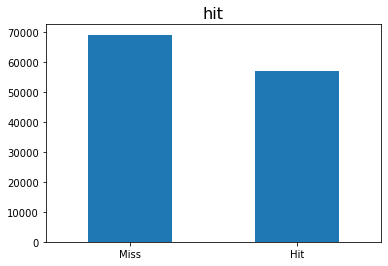

In [51]:
ax = shot_logs['fgm'].replace({
    0:'Miss',
    1:'Hit'
}).value_counts().plot.bar(rot=0)
ax.set_title('hit', fontsize=16)
plt.show()

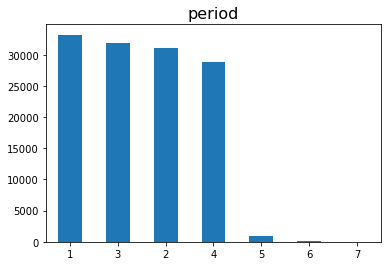

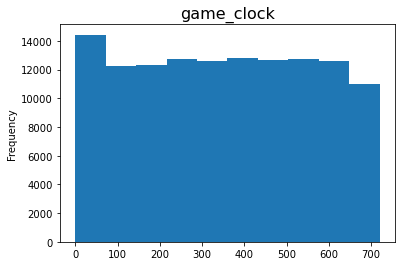

In [52]:
# if a game ends up in a tie, new periods are played until the match has a winner
# as the game progress, the number of shot attemps is reduced. Thus, in early game players tend to play faster and with more risk.
ax = shot_logs['period'].value_counts().plot.bar(rot=0)
ax.set_title('period', fontsize=16)
plt.show()

# The distributions are kind of uniform
plot_distribution('game_clock', bins=10)

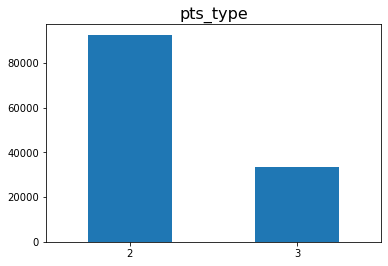

In [53]:
# roughly one third to the shots are behind the three points line.
ax = shot_logs['pts_type'].value_counts().plot.bar(rot=0)
ax.set_title('pts_type', fontsize=16)
plt.show()

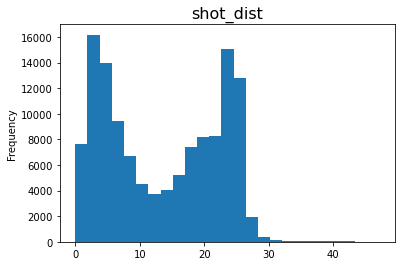

In [54]:
# distance is probably bimodal because of the three points field goal.
# there are some outliers above 30 ft, which probably happened due to the game clock.
plot_distribution('shot_dist', bins=25)

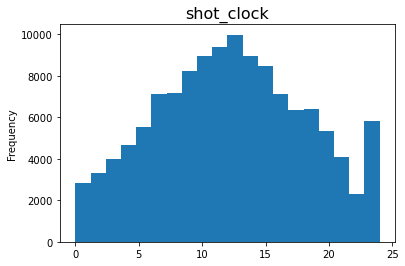

In [55]:
# kind of normal and has a peak in the end, which can be shots originated from rebounds.
plot_distribution('shot_clock', bins=20)

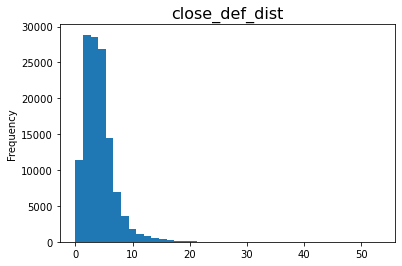

In [56]:
# most defensors tend to be up to 5 ft far from the shooter.
plot_distribution('close_def_dist', bins=40)

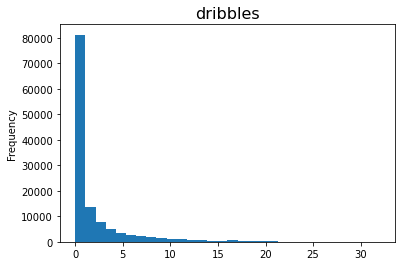

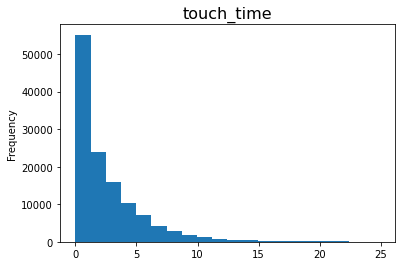

In [57]:
# Teams usually play together exchanging lots of passes and keeping low ball possession times.
# low dribbles and low touch_time
plot_distribution('dribbles', bins=30)
plot_distribution('touch_time', bins=20)

In [58]:
shot_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126056 entries, 0 to 126055
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   location          126056 non-null  int64  
 1   period            126056 non-null  int64  
 2   game_clock        126056 non-null  int64  
 3   shot_clock        126056 non-null  float64
 4   dribbles          126056 non-null  int64  
 5   touch_time        126056 non-null  float64
 6   shot_dist         126056 non-null  float64
 7   pts_type          126056 non-null  int64  
 8   closest_defender  126056 non-null  object 
 9   close_def_dist    126056 non-null  float64
 10  fgm               126056 non-null  int64  
 11  player_name       126056 non-null  object 
 12  FGA               126056 non-null  float64
 13  eFG%              126056 non-null  float64
 14  2PA               126056 non-null  float64
 15  3PA               126056 non-null  float64
 16  0~3               12

## Descriptive statistics

In [59]:
shot_logs.describe()

,location,period,game_clock,shot_clock,dribbles,touch_time,shot_dist,pts_type,close_def_dist,fgm,...,2PA,3PA,0~3,3~10,10~16,16~3P,3P%,STL%,BLK%,DBPM
count,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,...,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000,126056.000000
mean,0.499040,2.475186,351.008734,12.222342,2.029059,2.776237,13.579906,2.264716,4.122857,0.452291,...,7.988778,2.767298,0.622943,0.372983,0.385366,0.378154,0.302644,1.589027,1.773243,0.050649
std,0.500001,1.139844,207.730841,5.901163,3.484861,2.992350,8.894523,0.441183,2.755453,0.497721,...,3.901938,2.083206,0.067329,0.084722,0.098254,0.091639,0.131743,0.626464,1.618511,1.128433
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.300000,0.000000,0.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.700000
25%,0.000000,1.000000,172.000000,7.900000,0.000000,0.900000,4.700000,2.000000,2.300000,0.000000,...,5.100000,0.500000,0.582000,0.320000,0.333000,0.350000,0.284000,1.100000,0.600000,-0.700000
50%,0.000000,2.000000,352.000000,12.100000,1.000000,1.600000,13.700000,2.000000,3.700000,0.000000,...,7.500000,2.900000,0.624000,0.377000,0.400000,0.390000,0.342000,1.500000,1.200000,0.000000
75%,1.000000,3.000000,531.000000,16.500000,2.000000,3.700000,22.500000,3.000000,5.300000,1.000000,...,10.300000,4.300000,0.669000,0.433000,0.443000,0.432000,0.372000,2.000000,2.400000,0.700000
max,1.000000,7.000000,720.000000,24.000000,32.000000,24.900000,47.200000,3.000000,53.200000,1.000000,...,18.500000,8.100000,1.000000,0.625000,1.000000,0.625000,1.000000,8.700000,9.500000,8.700000


## Features and target relationships

In [60]:
# 2 points shots can be hit or a miss with the same probability
# however 3 points shots are converted only roughly one third of the attempts.
show_frequency('pts_type', 'fgm')

fgm,0,1,All
pts_type,,,
2,0.376023,0.359261,0.735284
3,0.171686,0.093030,0.264716
All,0.547709,0.452291,1.000000


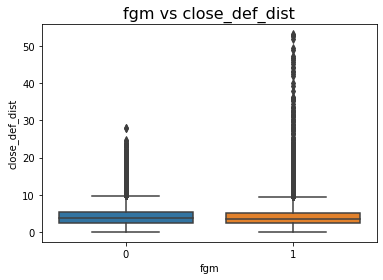

In [61]:
# the distribution of closest defender distance when the shot is hit has much more outliers.
# A theory that can explain that are rebound and counter-attacks.
plot_relationship('fgm', 'close_def_dist')

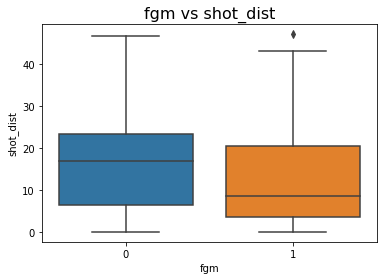

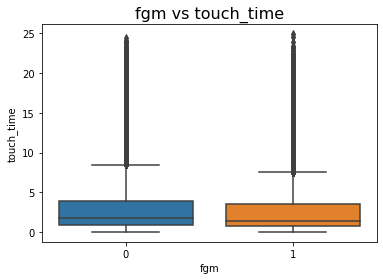

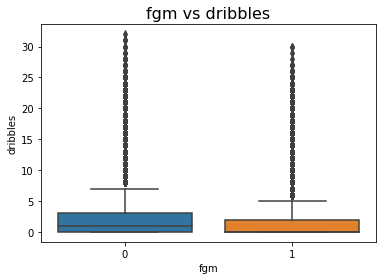

In [62]:
# hits tipically have smaller touch times, shot distances and dribbles.
plot_relationship('fgm', 'shot_dist')
plot_relationship('fgm', 'touch_time')
plot_relationship('fgm', 'dribbles')

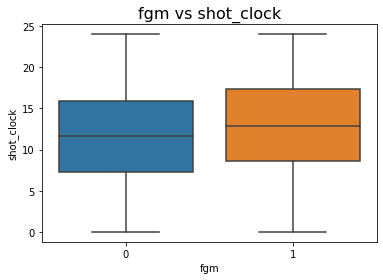

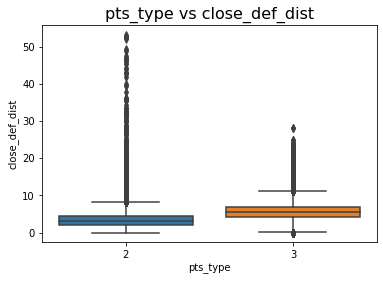

In [63]:
# 3 pt shots are more frequently tried when the defensive player is far from the shooter 
# and the offensive team has more shot time to develop the attack.
plot_relationship('fgm', 'shot_clock')
plot_relationship('pts_type', 'close_def_dist')

## Analyzing correlations

/var/folders/24/j32tgdrn7m126hvrjl8t778m0000gn/T/ipykernel_28310/719343148.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr_mask = np.zeros_like(x_corr, dtype=np.bool)


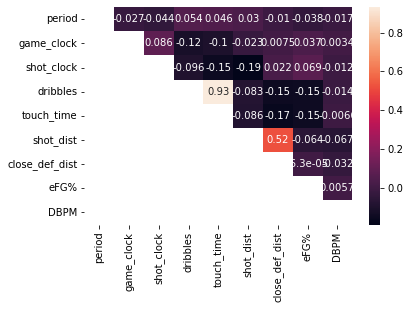

In [65]:
# There are some coefficients higher than 0.5
x_corr = shot_logs[['period', 'game_clock', 'shot_clock', 'dribbles', 'touch_time', 'shot_dist', 'close_def_dist','eFG%','DBPM']].corr()
corr_mask = np.zeros_like(x_corr, dtype=np.bool)
corr_mask[np.tril_indices_from(corr_mask, k=0)] = True

sns.heatmap(x_corr, mask = corr_mask, annot=True)
plt.show()

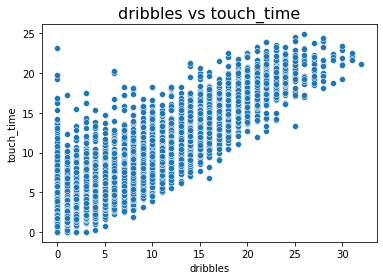

In [66]:
plot_scatter('dribbles', 'touch_time')

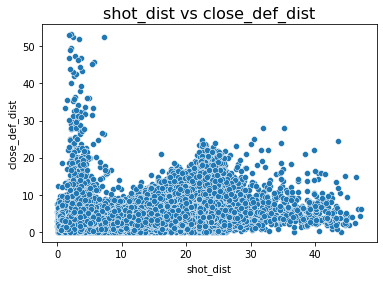

In [67]:
plot_scatter('shot_dist', 'close_def_dist')

## Outlier processing with IQR

In [68]:
#detecting outlier
q3 = shot_logs.quantile(0.75)
q1 = shot_logs.quantile(0.25)
iqr = q3-q1

/var/folders/24/j32tgdrn7m126hvrjl8t778m0000gn/T/ipykernel_28310/2377042929.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3 = shot_logs.quantile(0.75)
/var/folders/24/j32tgdrn7m126hvrjl8t778m0000gn/T/ipykernel_28310/2377042929.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1 = shot_logs.quantile(0.25)


In [69]:
outlier = shot_logs.copy()
shot_logs.info()
def is_kor_outlier(df, str):
    kor_score = df[str]
    outlier[str]= (kor_score > q3[str] + 1.5*iqr[str]) | (kor_score < q1[str]-1.5*iqr[str])
for i in outlier:
    if i == 'closest_defender' or 'player_name':
        continue
    is_kor_outlier(outlier, i)
    print('feature', i)
    print(outlier[i].value_counts(normalize = True, dropna = True))
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126056 entries, 0 to 126055
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   location          126056 non-null  int64  
 1   period            126056 non-null  int64  
 2   game_clock        126056 non-null  int64  
 3   shot_clock        126056 non-null  float64
 4   dribbles          126056 non-null  int64  
 5   touch_time        126056 non-null  float64
 6   shot_dist         126056 non-null  float64
 7   pts_type          126056 non-null  int64  
 8   closest_defender  126056 non-null  object 
 9   close_def_dist    126056 non-null  float64
 10  fgm               126056 non-null  int64  
 11  player_name       126056 non-null  object 
 12  FGA               126056 non-null  float64
 13  eFG%              126056 non-null  float64
 14  2PA               126056 non-null  float64
 15  3PA               126056 non-null  float64
 16  0~3               12

In [70]:
#outlier를 True 비율이 0.05를 넘으면 outlier replacement by minmax_scale
#dribbles, touch_time에서 outlier

In [71]:
dribbles_max = shot_logs['dribbles'].max()
dribbles_min = shot_logs['dribbles'].min()
dribbles_minmax = (shot_logs['dribbles']-dribbles_min)/(dribbles_max - dribbles_min)
shot_logs['dribbles'] = dribbles_minmax
print(shot_logs['dribbles'])

0         0.06250
1         0.00000
2         0.09375
3         0.06250
4         0.06250
           ...   
126051    0.15625
126052    0.12500
126053    0.06250
126054    0.12500
126055    0.15625
Name: dribbles, Length: 126056, dtype: float64


In [72]:
print(shot_logs['touch_time'])
touch_max = shot_logs['touch_time'].max()
touch_min = shot_logs['touch_time'].min()
touch_minmax = (shot_logs['touch_time']-touch_min)/(touch_max - touch_min)
shot_logs['touch_time'] = touch_minmax
print(shot_logs['touch_time'])

0         1.9
1         0.8
2         2.7
3         1.9
4         2.7
         ... 
126051    6.2
126052    5.2
126053    4.2
126054    4.5
126055    4.7
Name: touch_time, Length: 126056, dtype: float64
0         0.076305
1         0.032129
2         0.108434
3         0.076305
4         0.108434
            ...   
126051    0.248996
126052    0.208835
126053    0.168675
126054    0.180723
126055    0.188755
Name: touch_time, Length: 126056, dtype: float64


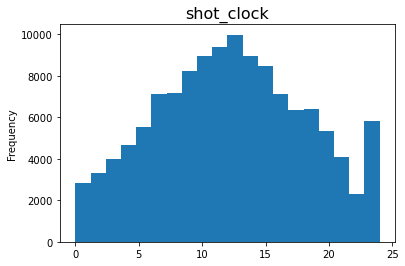

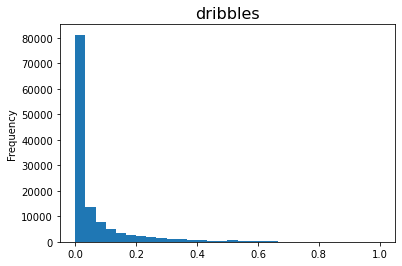

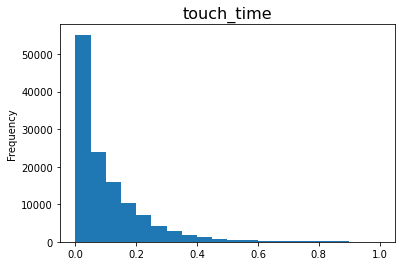

In [73]:
plot_distribution('shot_clock', bins=20)
plot_distribution('dribbles', bins=30)
plot_distribution('touch_time', bins=20)

In [75]:
len(shot_logs)

126056

In [76]:
shot_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126056 entries, 0 to 126055
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   location          126056 non-null  int64  
 1   period            126056 non-null  int64  
 2   game_clock        126056 non-null  int64  
 3   shot_clock        126056 non-null  float64
 4   dribbles          126056 non-null  float64
 5   touch_time        126056 non-null  float64
 6   shot_dist         126056 non-null  float64
 7   pts_type          126056 non-null  int64  
 8   closest_defender  126056 non-null  object 
 9   close_def_dist    126056 non-null  float64
 10  fgm               126056 non-null  int64  
 11  player_name       126056 non-null  object 
 12  FGA               126056 non-null  float64
 13  eFG%              126056 non-null  float64
 14  2PA               126056 non-null  float64
 15  3PA               126056 non-null  float64
 16  0~3               12

## Adding new features

In [78]:
shot_acc = []

for i in range(len(shot_logs)):
    d = shot_logs['shot_dist'][i]
    if 0<=d<=3:
        shot_acc.append(shot_logs['0~3'][i] * shot_logs['2PA'][i])
    elif 3<d<=10:
        shot_acc.append(shot_logs['3~10'][i] * shot_logs['2PA'][i])
    elif 10<d<=16:
        shot_acc.append(shot_logs['10~16'][i] * shot_logs['2PA'][i])
    elif 16<d<=22:
        shot_acc.append(shot_logs['16~3P'][i] * shot_logs['2PA'][i])
    else:
        shot_acc.append(shot_logs['3P%'][i] * shot_logs['3PA'][i])

shot_logs['shot_acc'] = shot_acc
shot_logs['shot_acc']

0         1.5696
1         0.8667
2         1.4256
3         1.5588
4         1.5696
           ...  
126051    4.2252
126052    5.0988
126053    3.8220
126054    3.8220
126055    4.2252
Name: shot_acc, Length: 126056, dtype: float64

In [79]:
fg = []
for i in range(len(shot_logs)):
    a = shot_logs['FGA'][i]
    per = shot_logs['eFG%'][i]
    fg.append(a * per)
    
shot_logs['fg'] = fg
shot_logs['fg']

0         2.8854
1         2.8854
2         2.8854
3         2.8854
4         2.8854
           ...  
126051    4.7226
126052    4.7226
126053    4.7226
126054    4.7226
126055    4.7226
Name: fg, Length: 126056, dtype: float64

In [80]:
shot_logs

,location,period,game_clock,shot_clock,dribbles,touch_time,shot_dist,pts_type,closest_defender,close_def_dist,...,0~3,3~10,10~16,16~3P,3P%,STL%,BLK%,DBPM,shot_acc,fg
0,0,1,69,10.8,0.06250,0.076305,7.7,2,"Anderson, Alan",1.3,...,0.511,0.436,0.396,0.433,0.321,1.7,0.2,0.2,1.5696,2.8854
1,0,1,14,3.4,0.00000,0.032129,28.2,3,"Bogdanovic, Bojan",6.1,...,0.511,0.436,0.396,0.433,0.321,0.9,0.4,-1.4,0.8667,2.8854
2,0,1,0,0.0,0.09375,0.108434,10.1,2,"Bogdanovic, Bojan",0.9,...,0.511,0.436,0.396,0.433,0.321,0.9,0.4,-1.4,1.4256,2.8854
3,0,2,707,10.3,0.06250,0.076305,17.2,2,"Brown, Markel",3.4,...,0.511,0.436,0.396,0.433,0.321,2.1,1.2,0.4,1.5588,2.8854
4,0,2,634,10.9,0.06250,0.108434,3.7,2,"Young, Thaddeus",1.1,...,0.511,0.436,0.396,0.433,0.321,2.7,0.8,-0.1,1.5696,2.8854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126051,0,3,112,18.3,0.15625,0.248996,8.7,2,"Smart, Marcus",0.8,...,0.607,0.503,0.395,0.455,0.267,2.7,0.8,1.5,4.2252,4.7226
126052,0,4,688,19.8,0.12500,0.208835,0.6,2,"Turner, Evan",0.6,...,0.607,0.503,0.395,0.455,0.267,1.8,0.7,0.8,5.0988,4.7226
126053,0,4,670,23.0,0.06250,0.168675,16.9,2,"Thornton, Marcus",4.2,...,0.607,0.503,0.395,0.455,0.267,1.6,0.8,-0.5,3.8220,4.7226
126054,0,4,157,9.1,0.12500,0.180723,18.3,2,"Bradley, Avery",3.0,...,0.607,0.503,0.395,0.455,0.267,1.7,0.5,-0.6,3.8220,4.7226


## Training

In [81]:
print(shot_logs.columns)
print(shot_logs.shape)

Index(['location', 'period', 'game_clock', 'shot_clock', 'dribbles',
       'touch_time', 'shot_dist', 'pts_type', 'closest_defender',
       'close_def_dist', 'fgm', 'player_name', 'FGA', 'eFG%', '2PA', '3PA',
       '0~3', '3~10', '10~16', '16~3P', '3P%', 'STL%', 'BLK%', 'DBPM',
       'shot_acc', 'fg'],
      dtype='object')
(126056, 26)


In [82]:
train, test = train_test_split(shot_logs, test_size=0.15, random_state=1)
train, val = train_test_split(train, test_size=0.18, random_state=1)
train.shape, val.shape, test.shape

((87860, 26), (19287, 26), (18909, 26))

In [83]:
#standard model for validation
majority_class = train["fgm"].mode()[0]

y_pred = [majority_class] * len(test)

print("최빈 클래스: ", majority_class)
print("validation 데이터셋 정확도: ", accuracy_score(test["fgm"], y_pred))

최빈 클래스:  0
validation 데이터셋 정확도:  0.5471997461526258


### #1. Logistic Regression

In [84]:
feature = ['location', 'period', 'game_clock', 'shot_clock', 'touch_time', 'shot_dist', 'close_def_dist', 'STL%', 'BLK%', 'DBPM', 'shot_acc', 'fg']
target = 'fgm'

X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]
y_test = test[target]

print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape, y_test.shape)

feature Matrix:  (87860, 12) (19287, 12) (18909, 12)
target vector:  (87860,) (19287,) (18909,)


In [85]:
#feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [90]:
logimodel = LogisticRegression(solver='saga', max_iter=5000)
logimodel.fit(X_train, y_train)

print("validation 데이터셋 정확도: ", logimodel.score(X_val, y_val))

validation 데이터셋 정확도:  0.616062632861513


In [97]:
X_total = pd.concat([X_train, X_val])
y_total = pd.concat([y_train, y_val])

feature = ['location', 'period', 'game_clock', 'shot_clock', 'touch_time', 'shot_dist', 'close_def_dist', 'STL%', 'BLK%', 'DBPM', 'shot_acc', 'fg']
target = 'fgm'

scaler = StandardScaler()

X_total_scaled = scaler.fit_transform(X_total)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='saga', max_iter=5000)
model.fit(X_total_scaled, y_total)

print("test 데이터셋 정확도")
model.score(X_test_scaled, y_test)

test 데이터셋 정확도


0.6112962081548469

close_def_dist    0.302795
shot_acc          0.113410
shot_clock        0.096901
STL%              0.036924
location          0.015976
period           -0.002638
fg               -0.004919
game_clock       -0.006094
DBPM             -0.060203
touch_time       -0.090369
BLK%             -0.093141
shot_dist        -0.537716
dtype: float64


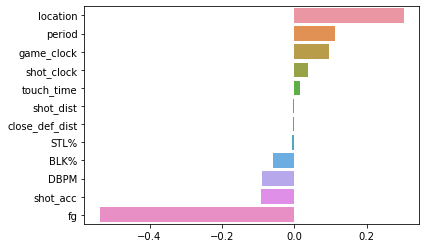

In [99]:
#feature coefficent

model_coef = pd.Series(model.coef_[0], feature).sort_values(ascending=False)
sns.barplot(x=model_coef, y=['location', 'period', 'game_clock', 'shot_clock', 'touch_time', 'shot_dist', 'close_def_dist', 'STL%', 'BLK%', 'DBPM', 'shot_acc', 'fg'])
print(model_coef)
plt.show()

### #2. Random Forest

In [100]:
feature = ['location', 'period', 'game_clock', 'shot_clock', 'touch_time', 'shot_dist', 'close_def_dist', 'STL%', 'BLK%', 'DBPM', 'shot_acc', 'fg']
target = 'fgm'

X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]
y_test = test[target]

print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape, y_test.shape)

feature Matrix:  (87860, 12) (19287, 12) (18909, 12)
target vector:  (87860,) (19287,) (18909,)


In [101]:
#feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [102]:
rfmodel = RandomForestClassifier(random_state=0)
rfmodel.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

In [103]:
print(rfmodel.score(X_val_scaled, y_val))

0.6106185513558355


In [104]:
rf_param_grid = {
    
    "n_estimators" : [100, 200],
    "max_depth" : [8, 10, 12],
    "min_samples_leaf" : [3, 5, 7],
    "min_samples_split" : [2, 3, 5]
    
}

In [105]:
#grid search
rf_gridsearch = GridSearchCV(rfmodel, rf_param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
rf_gridsearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [106]:
print(rf_gridsearch.best_score_)
print(rf_gridsearch.best_params_)

0.6228773048030958
{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}


In [107]:
rf_gridsearch.score(X_val_scaled, y_val) 

0.6225436822730337

In [108]:
X_total = pd.concat([X_train, X_val])
y_total = pd.concat([y_train, y_val])

feature = ['location', 'period', 'game_clock', 'shot_clock', 'touch_time', 'shot_dist', 'close_def_dist', 'STL%', 'BLK%', 'DBPM', 'shot_acc', 'fg']
target = 'fgm'

scaler = StandardScaler()

X_total_scaled = scaler.fit_transform(X_total)
X_test_scaled = scaler.transform(X_test)

rfmodel = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_split=2, min_samples_leaf=3, n_jobs=-1, verbose=1, random_state=0)
rfmodel.fit(X_total_scaled, y_total)

print("test 데이터셋 정확도")
rfmodel.score(X_test_scaled, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s


test 데이터셋 정확도


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.6221904913004389

### #3. XGBoost

In [109]:
feature = ['location', 'period', 'game_clock', 'shot_clock', 'touch_time', 'shot_dist', 'close_def_dist', 'STL%', 'BLK%', 'DBPM', 'shot_acc', 'fg']
target = 'fgm'

X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]
y_test = test[target]

print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape, y_test.shape)

feature Matrix:  (87860, 12) (19287, 12) (18909, 12)
target vector:  (87860,) (19287,) (18909,)


In [110]:
dtrain = xgb.DMatrix(data = X_train, label = y_train)
dval = xgb.DMatrix(data = X_val, label = y_val)
dtest = xgb.DMatrix(data = X_test)

In [115]:
params =  {'objective' : 'binary:logistic',
           'max_depth' : 8,
           'eta' : 0.02,
           'eval_metric' : 'logloss',
           'colsample_bytree' : 0.8, 
           'colsample_bylevel': 0.85,
           'seed': 2022}
         
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = 1000, 
                        early_stopping_rounds = 20, evals=[(dtrain,'train'),(dval,'eval')])

[0]	train-logloss:0.69115	eval-logloss:0.69144
[1]	train-logloss:0.68924	eval-logloss:0.68978
[2]	train-logloss:0.68740	eval-logloss:0.68820
[3]	train-logloss:0.68562	eval-logloss:0.68669
[4]	train-logloss:0.68388	eval-logloss:0.68520
[5]	train-logloss:0.68234	eval-logloss:0.68386
[6]	train-logloss:0.68073	eval-logloss:0.68246
[7]	train-logloss:0.67966	eval-logloss:0.68168
[8]	train-logloss:0.67815	eval-logloss:0.68039
[9]	train-logloss:0.67686	eval-logloss:0.67936
[10]	train-logloss:0.67549	eval-logloss:0.67818
[11]	train-logloss:0.67457	eval-logloss:0.67753
[12]	train-logloss:0.67379	eval-logloss:0.67704
[13]	train-logloss:0.67287	eval-logloss:0.67638
[14]	train-logloss:0.67153	eval-logloss:0.67527
[15]	train-logloss:0.67030	eval-logloss:0.67424
[16]	train-logloss:0.66906	eval-logloss:0.67325
[17]	train-logloss:0.66844	eval-logloss:0.67290
[18]	train-logloss:0.66724	eval-logloss:0.67191
[19]	train-logloss:0.66614	eval-logloss:0.67103
[20]	train-logloss:0.66507	eval-logloss:0.67019
[2

[170]	train-logloss:0.61369	eval-logloss:0.64463
[171]	train-logloss:0.61355	eval-logloss:0.64462
[172]	train-logloss:0.61342	eval-logloss:0.64459
[173]	train-logloss:0.61325	eval-logloss:0.64458
[174]	train-logloss:0.61318	eval-logloss:0.64458
[175]	train-logloss:0.61301	eval-logloss:0.64457
[176]	train-logloss:0.61291	eval-logloss:0.64455
[177]	train-logloss:0.61277	eval-logloss:0.64454
[178]	train-logloss:0.61270	eval-logloss:0.64455
[179]	train-logloss:0.61256	eval-logloss:0.64454
[180]	train-logloss:0.61245	eval-logloss:0.64455
[181]	train-logloss:0.61230	eval-logloss:0.64452
[182]	train-logloss:0.61217	eval-logloss:0.64451
[183]	train-logloss:0.61198	eval-logloss:0.64451
[184]	train-logloss:0.61184	eval-logloss:0.64448
[185]	train-logloss:0.61169	eval-logloss:0.64447
[186]	train-logloss:0.61163	eval-logloss:0.64447
[187]	train-logloss:0.61148	eval-logloss:0.64445
[188]	train-logloss:0.61141	eval-logloss:0.64444
[189]	train-logloss:0.61132	eval-logloss:0.64444
[190]	train-logloss:

In [116]:
# 예측하기, 확률값으로 반환됨
y_pred_probs = xgb_model.predict(dtest)

# 0또는 1로 변경
y_preds = [1 if x > 0.5 else 0 for x in y_pred_probs]

#성능 평가
print(confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds))
print(accuracy_score(y_test, y_preds))

[[8701 1646]
 [5481 3081]]
              precision    recall  f1-score   support

           0       0.61      0.84      0.71     10347
           1       0.65      0.36      0.46      8562

    accuracy                           0.62     18909
   macro avg       0.63      0.60      0.59     18909
weighted avg       0.63      0.62      0.60     18909

0.6230895340842985


### #4. Multi-Layer Perceptron

In [117]:
feature = ['location', 'period', 'game_clock', 'shot_clock', 'touch_time', 'shot_dist', 'close_def_dist', 'STL%', 'BLK%', 'DBPM', 'shot_acc', 'fg']
target = 'fgm'

X_train = train[feature]
y_train = train[target]

X_val = val[feature]
y_val = val[target]

X_test = test[feature]
y_test = test[target]

print("feature Matrix: ", X_train.shape, X_val.shape, X_test.shape)
print("target vector: ", y_train.shape, y_val.shape, y_test.shape)

#feature scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

feature Matrix:  (87860, 12) (19287, 12) (18909, 12)
target vector:  (87860,) (19287,) (18909,)


In [174]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(12,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=30, batch_size=512)
results = model.evaluate(X_val_scaled, y_val)

Epoch 1/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6620 - accuracy: 0.6042
Epoch 2/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6537 - accuracy: 0.6149
Epoch 3/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6519 - accuracy: 0.6165
Epoch 4/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6513 - accuracy: 0.6179
Epoch 5/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6501 - accuracy: 0.6198
Epoch 6/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6498 - accuracy: 0.6192
Epoch 7/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.6207
Epoch 8/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6492 - accuracy: 0.6212
Epoch 9/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.6208
Epoch 10/30
172/172 [==============================] - 0s 2ms/step - loss: 0.6487 - accuracy: 0.6211

### Ensemble

In [187]:
X_total = pd.concat([X_train, X_val])
y_total = pd.concat([y_train, y_val])

feature = ['location', 'period', 'game_clock', 'shot_clock', 'touch_time', 'shot_dist', 'close_def_dist', 'STL%', 'BLK%', 'DBPM', 'shot_acc', 'fg']
target = 'fgm'

scaler = StandardScaler()

X_total_scaled = scaler.fit_transform(X_total)
X_test_scaled = scaler.transform(X_test)

rfresult = rfmodel.predict_proba(X_test_scaled)[:,1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [188]:
xgbresult = y_pred_probs

In [216]:
mlpresult = model.predict(X_test_scaled)
mlpresult = mlpresult.flatten()
mlpresult.shape

591/591 [==============================] - 0s 338us/step


(18909,)

In [288]:
test_probs = np.add(np.add(0.15*rfresult, 0.25*xgbresult), 0.6*mlpresult)

In [286]:
print(test_probs)

[0.31468812 0.34576755 0.41051508 ... 0.4841781  0.50982029 0.93508684]


In [287]:
y_test = list(y_test)

In [284]:
test_pred = test_probs > 0.5

correct = 0
for i in range(len(test_pred)):
    pred = 0
    if test_pred[i]: pred = 1
    if pred == y_test[i]:
        correct += 1
        
print('ensemble accuracy : ', end = '')
print(correct / len(test_pred) ) 

ensemble accuracy : 0.6201808662541647


In [291]:
#hyperparameter tuning
maxa = 0.0
maxp = ()

for i in range(0, 100):
    mlp = i / 100.0
    for j in range(0, 100-i):
        xgb = j / 100.0
        rfr = 1.0 - mlp - xgb
        
        test_probs = np.add(np.add(rfr*rfresult, xgb*xgbresult), mlp*mlpresult)
        
        y_test = list(y_test)
        
        test_pred = test_probs > 0.5
        
        correct = 0
        for i in range(len(test_pred)):
            pred = 0
            if test_pred[i]: pred = 1
            if pred == y_test[i]:
                correct += 1
                
        accuracy = correct/len(test_pred)
        if maxa < accuracy:
            maxa = accuracy
            maxp =(rfr, xgb, mlp)
            
print('ensemble accuary : ', end ='')
print(maxa)
print('max hyperparameter : ', end='')
print(maxp)

ensemble accuary : 0.6232481886932149
max hyperparameter : (0.020000000000000018, 0.79, 0.19)
